# Import Libraries

In [2]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.3 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=bbb59c7a533b93181f8caffa3055d95b8c30a2d9da95ce41ee9a13971ea860bc
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6964871e74e35c4023ba248ec6bb2f08889ebf9e6eecd622e17d33a0bc8ef23b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [3]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split


In [4]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import warnings
warnings.filterwarnings('ignore')
import torchvision.utils as vutils
from torchvision import models

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, StepLR, MultiStepLR, CyclicLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image

In [5]:
import os
import cv2
import hashlib
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as vutils
from PIL import Image, ImageDraw, ImageFont

# Data Preprocessing

In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class DRIVEDataset(Dataset):
    def __init__(self, root_dir):
        self.input_data = os.path.join(root_dir, 'DRIVE/training/images')
        self.target_data = os.path.join(root_dir, 'DRIVE/training/mask')
        self.image_exts = ('.tif',)  # Image file extensions
        self.mask_exts = ('.gif',)   # Mask file extensions
        self.images = self._get_files(self.input_data, self.image_exts)
        self.masks = self._get_files(self.target_data, self.mask_exts)
        print("Number of images:", len(self.images))
        print("Number of masks:", len(self.masks))
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            # Add more transformations if needed
        ])
        assert len(self.images) == len(self.masks), "Number of images and masks must be the same"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        if image.size != mask.size:
            raise ValueError(f"Image size {image.size} and mask size {mask.size} do not match.")

        # Apply transformations
        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask
        
    def _get_files(self, data_dir, extensions):
        files = sorted([
            os.path.join(data_dir, fname)
            for fname in os.listdir(data_dir)
            if fname.endswith(extensions) and not fname.startswith(".")
        ])
        return files

# Example usage:
root_dir = '/kaggle/input/retinal-vessel-segmentation'

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = DRIVEDataset(root_dir)

# Dataloader setup
batch_size = 5
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Iterate through the dataloader
for images, masks in dataloader:
    # Move tensors to the appropriate device (GPU if available)
    images = images.to(device)
    masks = masks.to(device)

    # Training loop or any further processing
    print("Batch size:", images.shape[0])


Using device: cuda
Number of images: 20
Number of masks: 20
Batch size: 5
Batch size: 5
Batch size: 5
Batch size: 5


In [8]:
# Iterate through the dataloader
for images, masks in dataloader:
    # Training loop or any further processing
    print("Batch size:", images.shape[0])
    print("Images length:", len(images))
    print("Masks length:", len(masks))
    # Print first few file paths for debugging
    for i in range(5):
        print("Image path:", dataset.images[i])
        print("Mask path:", dataset.masks[i])


Batch size: 5
Images length: 5
Masks length: 5
Image path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/images/21_training.tif
Mask path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/mask/21_training_mask.gif
Image path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/images/22_training.tif
Mask path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/mask/22_training_mask.gif
Image path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/images/23_training.tif
Mask path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/mask/23_training_mask.gif
Image path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/images/24_training.tif
Mask path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/mask/24_training_mask.gif
Image path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/images/25_training.tif
Mask path: /kaggle/input/retinal-vessel-segmentation/DRIVE/training/mask/25_training_mask.gif
Batch size: 5
Images le

In [9]:
for images, masks in dataloader:
    for image in images:
        print(image.shape)


torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


In [10]:
for images, masks in dataloader:
    for mask in masks:
        print(mask.shape)


torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [11]:
for images,masks in dataloader:
    print("batch size:", images.shape)

batch size: torch.Size([5, 3, 512, 512])
batch size: torch.Size([5, 3, 512, 512])
batch size: torch.Size([5, 3, 512, 512])
batch size: torch.Size([5, 3, 512, 512])


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 20))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        # Plot NumPy array directly
        plt.imshow(image, cmap='gray')  # Assuming images are grayscale
    plt.show()

# Example usage:
# Assume you have a NumPy array named 'output_image'
# You can visualize it like this:
# visualize(output_image=output_image)


Number of images: 20
Number of masks: 20
Mask min: 0.0
Mask max: 1.0
Unique values in mask: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.317

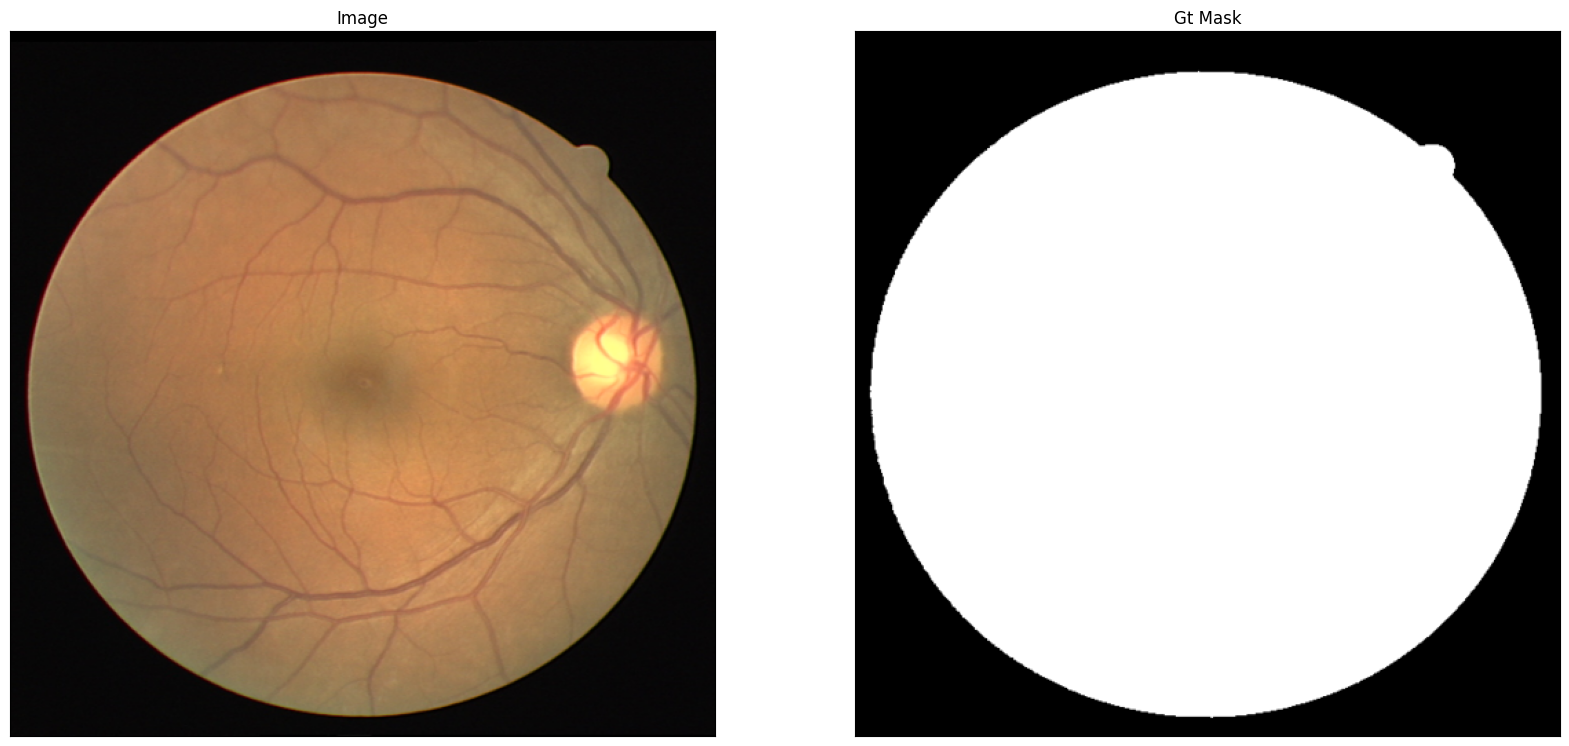

In [13]:
import torch
import numpy as np

# Assuming visualize function is defined as previously mentioned
# Assuming DRIVEDataset is defined as per the provided code

# Example usage:
root_dir = '/kaggle/input/retinal-vessel-segmentation'
train_dataset = DRIVEDataset(root_dir)

# Assuming visualize function is defined as previously mentioned

# Extract a batch from the dataset using DataLoader
image, mask = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)))

# Convert PyTorch tensors to NumPy arrays for visualization
image = image.squeeze().permute(1, 2, 0).numpy()  # Assuming image is of shape (C, H, W)
mask = mask.squeeze().numpy()  # Assuming mask is of shape (H, W)

# Print mask statistics
print("Mask min:", mask.min())
print("Mask max:", mask.max())
print("Unique values in mask:", np.unique(mask))

# Visualize images and masks
visualize(image=image, gt_mask=mask)


# Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, dilation=1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, dilation=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class TransUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(TransUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64, dilation=2)  # Set dilation=2 for the first convolutional layer

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)

        logits = self.outc(x9)
        logits = torch.sigmoid(logits)
        return logits


# Metrics

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

def calculate_accuracy(outputs, masks):
    predicted = outputs > 0.5  # Assuming binary classification
    correct = (predicted == masks.byte()).float()  # Convert masks to byte tensor for comparison
    accuracy = correct.sum() / torch.numel(masks)
    return accuracy.item()

def calculate_dice_coefficient(outputs, masks):
    smooth = 1e-6  # Smoothing factor to avoid division by zero
    predicted = outputs > 0.5  # Assuming binary classification
    intersection = (predicted & masks.byte()).float().sum()
    union = predicted.float().sum() + masks.float().sum()
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coefficient.item()

# Train

In [16]:
def train(model, dataloader, criterion, optimizer, device, epochs=100):
    model.train()  # Set the model to train mode
    for epoch in range(epochs):
        running_loss = 0.0
        running_accuracy = 0.0
        running_dice = 0.0
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item() * images.size(0)
            running_accuracy += calculate_accuracy(outputs, masks) * images.size(0)
            running_dice += calculate_dice_coefficient(outputs, masks) * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = running_accuracy / len(dataloader.dataset)
        epoch_dice = running_dice / len(dataloader.dataset)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Dice: {epoch_dice:.4f}")

# Define your model, optimizer, and loss function
model = TransUNet(n_channels=3, n_classes=1)  # Assuming 3 input channels (RGB) and 1 output channel
model.to(device)  # Move model to appropriate device

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss since we're dealing with binary segmentation

# Train the model
train(model, dataloader, criterion, optimizer, device, epochs=100)

Epoch 1/100, Loss: 0.4040, Accuracy: 0.8603, Dice: 0.8719
Epoch 2/100, Loss: 0.1922, Accuracy: 0.9961, Dice: 0.9942
Epoch 3/100, Loss: 0.1693, Accuracy: 0.9971, Dice: 0.9950
Epoch 4/100, Loss: 0.1520, Accuracy: 0.9971, Dice: 0.9950
Epoch 5/100, Loss: 0.1366, Accuracy: 0.9973, Dice: 0.9951
Epoch 6/100, Loss: 0.1233, Accuracy: 0.9971, Dice: 0.9949
Epoch 7/100, Loss: 0.1115, Accuracy: 0.9971, Dice: 0.9950
Epoch 8/100, Loss: 0.1011, Accuracy: 0.9968, Dice: 0.9947
Epoch 9/100, Loss: 0.0919, Accuracy: 0.9967, Dice: 0.9947
Epoch 10/100, Loss: 0.0837, Accuracy: 0.9967, Dice: 0.9947
Epoch 11/100, Loss: 0.0765, Accuracy: 0.9966, Dice: 0.9946
Epoch 12/100, Loss: 0.0703, Accuracy: 0.9967, Dice: 0.9947
Epoch 13/100, Loss: 0.0647, Accuracy: 0.9965, Dice: 0.9946
Epoch 14/100, Loss: 0.0599, Accuracy: 0.9957, Dice: 0.9940
Epoch 15/100, Loss: 0.0556, Accuracy: 0.9967, Dice: 0.9947
Epoch 16/100, Loss: 0.0519, Accuracy: 0.9962, Dice: 0.9943
Epoch 17/100, Loss: 0.0488, Accuracy: 0.9953, Dice: 0.9937
Epoch 

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, mask, output):
    """
    Display the input image, ground truth mask, and predicted mask
    """
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    # Plot input image
    axs[0].imshow(np.transpose(image.squeeze().cpu().detach().numpy(), (1, 2, 0)))
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    
    # Plot ground truth mask
    axs[1].imshow(mask.squeeze().numpy(), cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')
    
    # Plot predicted mask
    # Plot predicted mask
    axs[2].imshow(output.squeeze().cpu().detach().numpy(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    
    plt.show()


# Test

In [24]:
class TestDataset(Dataset):
    def __init__(self, root_dir):
        self.input_data = os.path.join(root_dir, 'DRIVE/test/images')
        self.target_data = os.path.join(root_dir, 'DRIVE/test/mask')
        self.image_exts = ('.tif',)  # Image file extensions
        self.mask_exts = ('.gif',)   # Mask file extensions
        self.images = self._get_files(self.input_data, self.image_exts)
        self.masks = self._get_files(self.target_data, self.mask_exts)
        print("Number of test images:", len(self.images))
        print("Number of test masks:", len(self.masks))
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            # Add more transformations if needed
        ])
        assert len(self.images) == len(self.masks), "Number of images and masks must be the same"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        if image.size != mask.size:
            raise ValueError(f"Image size {image.size} and mask size {mask.size} do not match.")

        # Apply transformations
        image = self.transform(image)
        mask = self.transform(mask)

        return image, mask
        
    def _get_files(self, data_dir, extensions):
        files = sorted([
            os.path.join(data_dir, fname)
            for fname in os.listdir(data_dir)
            if fname.endswith(extensions) and not fname.startswith(".")
        ])
        return files

In [25]:
test_dataset = TestDataset(root_dir)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of test images: 20
Number of test masks: 20


Test Accuracy: 0.9949, Test Dice: 0.9934


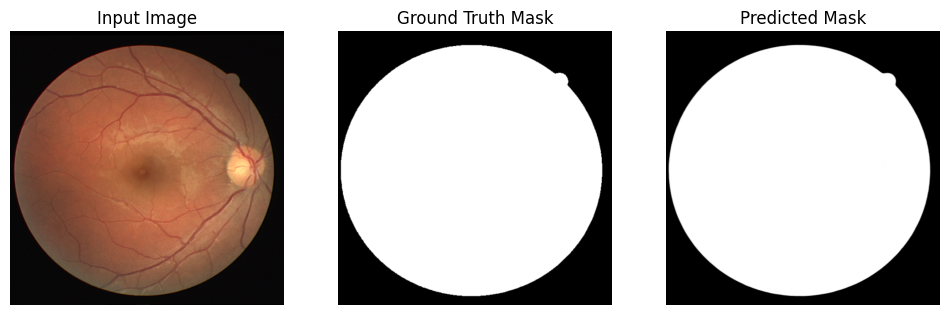

In [29]:
def test(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_accuracy = 0.0
    total_dice = 0.0
    total_samples = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)  # Forward pass

            # Calculate accuracy and dice coefficient
            total_accuracy += calculate_accuracy(outputs, masks) * images.size(0)
            total_dice += calculate_dice_coefficient(outputs, masks) * images.size(0)
            total_samples += images.size(0)

    avg_accuracy = total_accuracy / total_samples
    avg_dice = total_dice / total_samples

    print(f"Test Accuracy: {avg_accuracy:.4f}, Test Dice: {avg_dice:.4f}")


# Test the model
test(model, test_dataloader, device)

#display output
image = images[0]  # Example image from the dataset
mask = masks[0]    # Corresponding ground truth mask
output = model(image.unsqueeze(0).to(device))  # Model prediction for the image

# Display the images
display_image(image, mask, output)